# Transformers with Keras

In [1]:
# Import Keras and Packages

import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from keras.layers import Layer
import warnings
warnings.simplefilter('ignore', FutureWarning)

## Data

In [2]:
# Sample parallel sentences (English -> Portuguese)

input_texts = [
    "Hello.", "How are you?", "I am learning machine translation.", "What is your name?", "I love programming."
]
target_texts = [
    "Oi.", "Tudo bem?", "Estou aprendendo sobre tradução automática.", "Como você se chama?", "Eu gosto de programar."
]

target_texts = ["startseq " + x + " endseq" for x in target_texts]

In [3]:
# Convert the text from the sentences to tokens and create a vocabulary

# Tokenization
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)

output_tokenizer = Tokenizer()
output_tokenizer.fit_on_texts(target_texts)
output_sequences = output_tokenizer.texts_to_sequences(target_texts)

input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

In [4]:
# Padding

max_input_length = max([len(seq) for seq in input_sequences])
max_output_length = max([len(seq) for seq in output_sequences])

input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

In [5]:
# Prepare the target data for training

decoder_input_data = output_sequences[:, :-1]
decoder_output_data = output_sequences[:, 1:]

# Convert to one-hot
decoder_output_data = np.array([np.eye(output_vocab_size)[seq] for seq in decoder_output_data])

## Self-Attention Layer

Self-attention is a mechanism that allows a model to **focus on relevant parts of the input sequence** while processing each word. This is particularly useful in:
1) Machine Translation (e.g., aligning words correctly)
2) Text Summarization
3) Speech Recognition
4) Image Processing (Vision Transformers)
In this implementation, self-attention is used for text based sequence-to-sequence modeling.


Self-Attention works for a given an input sequence by computing a weighted representation of all words for each position. It does so using three key components:

1. Query **(Q)**, Key **(K)**, and Value **(V)** Matrices
For each word (token) in a sequence:

Query (Q): What this word is looking for.
Key (K): What this word represents.
Value (V): The actual information in the word.

2. Compute **Attention Scores**
Next, we **calculate the similarity between each query and key** using dot-product attention:
Each word in a sequence attends to every other word based on these scores.

3. Apply **Scaling & Softmax**
Since dot-product values can be large, we scale them.
Next, Applying softmax converts scores into attention weights:

### Self-Attention class
In this implementation of self-attention layer:
1. We first initialize the weights in the **build** method, where:
    1. **self.Wq**, **self.Wk**, **self.Wv** are the trainable weight matrices.
    2. Their **shape is (feature_dim, feature_dim)**, meaning they transform input features into Q, K, and V representations.
2. Applying Attention using **call** method. The **call()** method:
   1. Computes **Q, K, V** by multiplying inputs (encoder/decoder output) with their respective weight matrices.
   2. Computes **dot-product attention scores** using K.batch_dot(q, k, axes=[2, 2]), resulting in a (batch_size, seq_len, seq_len) matrix.
   3. **Scales** the scores to avoid large values.
   4. Applies **softmax** to normalize the attention scores.
   5. **Multiplies attention weights with V** to get the final output.
3. The **compute_output_shape** method defines the shape of the output tensor after the layer processes an input.
    1. The output shape of the Self-Attention layer **remains the same** as the input shape.
    2. The attention mechanism **transforms** the input but does not change its dimensions.4
    3. If the attention layer changed the shape, you would modify compute_output_shape

In [6]:
# Define the Self-Attention Layer

class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

## Model Architecture
The model follows an Encoder-Decoder structure:

### **Encoder**
1) Takes input sentences (padded and tokenized).

2) Uses an Embedding layer (word representations) + LSTM (to process sequences).
    The LSTMs are used as the **help process variable-length input sentences** and generate meaningful translations.

3) Outputs context vectors (hidden & cell states).

### **Attention Layer**
1) Applied to both the encoder and decoder outputs.

2) Helps the decoder focus on relevant words during translation.

### **Decoder**
1) Receives target sequences (shifted one step ahead).

2) Uses an LSTM with encoder states as initial states.

3) Applies self-attention for better learning.

4) Uses a Dense layer (Softmax) to predict the next word.

In [7]:
# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Attention Mechanism
attention_layer = SelfAttention()(encoder_outputs)

# Decoder
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_attention = SelfAttention()(decoder_outputs)  # Apply attention
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_attention)

# Full Model
model1 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 5, 256)    │      4,096 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 6, 256)    │      4,864 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 5, 256),  │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 6, 256),  │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention_1    │ (None, 6, 256)    │    196,608 │ lstm_1[0][0]      │
│ (SelfAttention)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6, 19)     │      4,883 │ self_attention_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,261,075 (4.81 MB)

 Trainable params: 1,261,075 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [8]:
# Train the Model
# Using categorical_crossentropy as the loss function since
# output words are one-hot encoded. Trains using Adam optimizer for 100 epochs.

history_glorot_adam = model1.fit([input_sequences, decoder_input_data],
                                decoder_output_data,
                                epochs=100,
                                batch_size=16,
                                validation_split=0.2)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0000e+00 - loss: 2.9494 - val_accuracy: 0.1667 - val_loss: 2.9388
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.3750 - loss: 2.9048 - val_accuracy: 0.1667 - val_loss: 2.9332
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.3750 - loss: 2.8529 - val_accuracy: 0.1667 - val_loss: 2.9243
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.3750 - loss: 2.7791 - val_accuracy: 0.1667 - val_loss: 2.9108
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3333 - loss: 2.6671 - val_accuracy: 0.1667 - val_loss: 2.8959
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.3333 - loss: 2.5018 - val_accuracy: 0.1667 - val_loss: 2.9016
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3333 - loss: 2.2982 - val_accuracy: 0.1667 - val_loss: 3.0408
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3333 - loss: 2.2289 - val_accuracy: 0.1667 - 

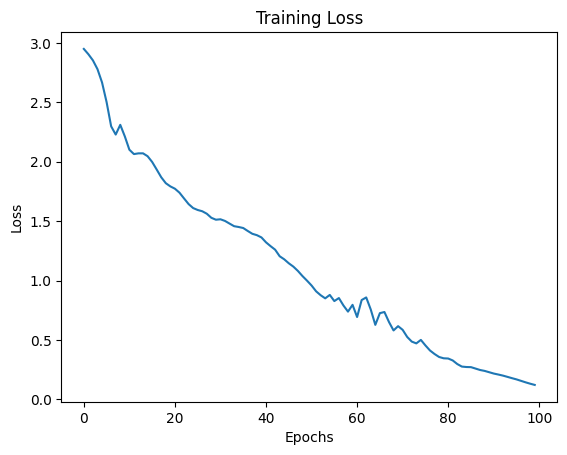

In [9]:
# Plotting training loss

import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Another Model

Let's train a model using "he_uniform" initializer instead of "glorot_uniform". Then, compare the training loss between model using "glorot_uniform" vs "he_uniform" initializers.

In [11]:
#Define the Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        # Weight matrices for Q, K, V
        self.Wq = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='he_uniform',
                                  trainable=True,
                                  name='Wq')
        self.Wk = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='he_uniform',
                                  trainable=True,
                                  name='Wk')
        self.Wv = self.add_weight(shape=(feature_dim, feature_dim),
                                  initializer='he_uniform',
                                  trainable=True,
                                  name='Wv')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        # Linear projections
        q = K.dot(inputs, self.Wq)  # Query
        k = K.dot(inputs, self.Wk)  # Key
        v = K.dot(inputs, self.Wv)  # Value

        # Scaled Dot-Product Attention
        scores = K.batch_dot(q, k, axes=[2, 2])  # (batch, seq_len, seq_len)
        scores = scores / K.sqrt(K.cast(K.shape(k)[-1], dtype=K.floatx()))  # Scale
        attention_weights = K.softmax(scores, axis=-1)  # Normalize

        # Weighted sum of values
        output = K.batch_dot(attention_weights, v)  # (batch, seq_len, feature_dim)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape


#Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_vocab_size, 256)(encoder_inputs)
encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

#Attention Mechanism
attention_layer = SelfAttention()(encoder_outputs)

#Decoder
decoder_inputs = Input(shape=(max_output_length - 1,))
decoder_embedding = Embedding(output_vocab_size, 256)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_attention = SelfAttention()(decoder_outputs)  # Apply attention
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_attention)

#Full Model
model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#Step 6: Train the Model
history_he = model2.fit([input_sequences, decoder_input_data],
                       decoder_output_data,
                       epochs=100,
                       batch_size=16,
                       validation_split=0.2)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.0000e+00 - loss: 2.9476 - val_accuracy: 0.1667 - val_loss: 2.9299
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step - accuracy: 0.3750 - loss: 2.8857 - val_accuracy: 0.1667 - val_loss: 2.9192
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.3333 - loss: 2.8146 - val_accuracy: 0.1667 - val_loss: 2.9037
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.3333 - loss: 2.7169 - val_accuracy: 0.1667 - val_loss: 2.8830
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.3333 - loss: 2.5752 - val_accuracy: 0.1667 - val_loss: 2.8659
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3333 - loss: 2.3831 - val_accuracy: 0.1667 - val_loss: 2.9013
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.3333 - loss: 2.2081 - val_accuracy: 0.1667 - val_loss: 3.1598
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.3333 - loss: 2.2694 - val_accuracy: 0.1667 - 

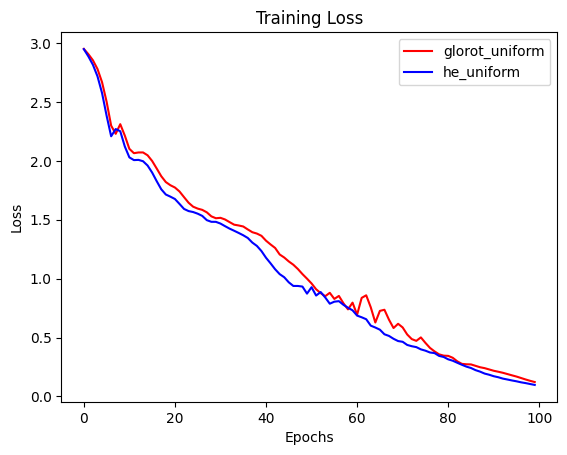

In [12]:
#Plotting training losses for glorot_uniform and he_uniform inititalizers
import matplotlib.pyplot as plt
plt.plot(history_glorot_adam.history['loss'], label="glorot_uniform", color='red')
plt.plot(history_he.history['loss'], label="he_uniform", color='blue')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
import matplotlib.pyplot as plt

def plot_history(histories, names):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        if 'accuracy' in history.history:
            plt.plot(history.history['accuracy'], label=f'{name} Train')
            plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


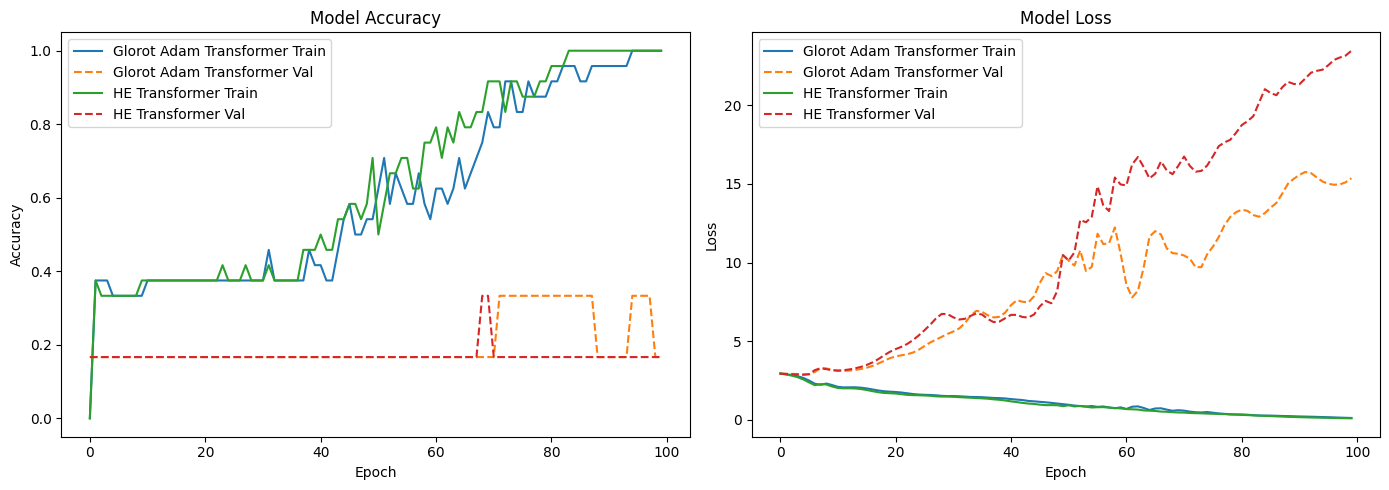

In [14]:
histories = [history_glorot_adam, history_he]
names = ['Glorot Adam Transformer', 'HE Transformer']
models = [model1, model2]
plot_history(histories, names)

In [19]:
# Evaluate the best model

def select_and_save_best_model(model1, model2, history1, history2, names):
    # Evaluate both models
    loss1 = history1.history['loss'][-1]
    acc1 = history1.history.get('accuracy', [0])[-1]

    loss2 = history2.history['loss'][-1]
    acc2 = history2.history.get('accuracy', [0])[-1]

    print(f"{names[0]} — Accuracy: {acc1:.4f}, Loss: {loss1:.4f}")
    print(f"{names[1]} — Accuracy: {acc2:.4f}, Loss: {loss2:.4f}")

    # Select best based on highest accuracy (fallback: lowest loss)
    if acc1 >= acc2:
        best_model = model1
        best_name = names[0]
    else:
        best_model = model2
        best_name = names[1]

    best_model.save('best_transformer_model.keras')
    print(f"🏆 Best model saved as 'best_transformer_model.keras': {best_name}")

In [20]:
select_and_save_best_model(
    model1=model1,
    model2=model2,
    history1=history_glorot_adam,
    history2=history_he,
    names=['Glorot Adam Transformer', 'HE Transformer']
)


Glorot Adam Transformer — Accuracy: 1.0000, Loss: 0.1226
HE Transformer — Accuracy: 1.0000, Loss: 0.0982
🏆 Best model saved as 'best_transformer_model.keras': Glorot Adam Transformer
